# Import

In [6]:
import tensorflow as tf
from tensorflow import keras

import numpy as np
import matplotlib.pyplot as plt

import IPython.display as display
from PIL import Image
import pathlib

from tensorflow.keras.preprocessing.image import ImageDataGenerator

print("Tensorflow version %s" %tf.__version__)
print("Keras version %s" %keras.__version__)

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Tensorflow version 2.3.1
Keras version 2.4.0
Found GPU at: /device:GPU:0


# Utility functions

In [7]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

In [8]:
def visualize(original, augmented):
  fig = plt.figure()
  plt.subplot(1,2,1)
  plt.title('Original image')
  plt.imshow(original)

  plt.subplot(1,2,2)
  plt.title('Augmented image')
  plt.imshow(augmented)


In [9]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        #print("Normalized confusion matrix")
    else:
        pass
        #print('Confusion matrix, without normalization')

    #print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    ax.set_ylim(len(classes)-0.5, -0.5)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

# CNN class

In [ ]:
# class CNN(nn.Module):

#     def _name(self):
#         return "CNN"

#     def _conv2d(self, in_channels, out_channels):
#         return nn.Conv2d(
#             in_channels=in_channels,
#             out_channels=out_channels,
#             kernel_size=3,
#             padding=1
#         )

#     def _build_models(self):
#         self.conv1 = nn.Sequential(
#             self._conv2d(self.channels_size, self.hidden_size),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size),
#             nn.MaxPool2d(2, 2)
#         )
#         self.conv2 = nn.Sequential(
#             self._conv2d(self.hidden_size , self.hidden_size * 2),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size * 2),
#             nn.MaxPool2d(2, 2)
#         )
#         self.conv3 = nn.Sequential(
#             self._conv2d(self.hidden_size*2, self.hidden_size * 4),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(self.hidden_size * 4),
#             nn.MaxPool2d(2, 2)
#         )
#         self.dense = nn.Sequential(
#             nn.Flatten(),
#             nn.Linear(int(self.hidden_size * 4 * img_dim/8 * img_dim/8), img_dim*4),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(img_dim*4, class_number),
#             nn.Softmax(dim=1)
#         )
#         return self.conv1, self.conv2, self.conv3, self.dense

#     def __init__(self, hidden_size, channels_size, class_number):
#         super().__init__()
#         self.hidden_size = hidden_size
#         self.channels_size = channels_size
#         self.class_number = class_number
#         self._models = self._build_models()
#         self.name = self._name()

#     def forward(self, image):
#         x = self._models[0](image)
#         x_1 = self._models[1](x)
#         x_2 = self._models[2](x_1)
#         x_3 = self._models[3](x_2)
#         return x_3

# Load data

In [10]:

data_dir = "./TestDataset/"
data_dir = pathlib.Path(data_dir)
print("Path:", data_dir)

Path: TestDataset


In [11]:
image_count = len(list(data_dir.glob('*/*.png')))
print("Total number of images:", image_count)

image_dict = np.array([{item.name: len(list(item.glob('*.png')))} for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print(image_dict)

Total number of images: 212
[{'Density4Benign': 12} {'Density1Benign': 24} {'Density3Malignant': 16}
 {'Density3Benign': 26} {'Density4Malignant': 2} {'Density2Benign': 8}
 {'Density1Malignant': 60} {'Density2Malignant': 64}]


In [12]:
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
print("Class names:",CLASS_NAMES)

Class names: ['Density4Benign' 'Density1Benign' 'Density3Malignant' 'Density3Benign'
 'Density4Malignant' 'Density2Benign' 'Density1Malignant'
 'Density2Malignant']


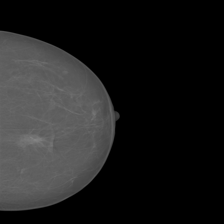

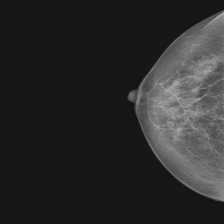

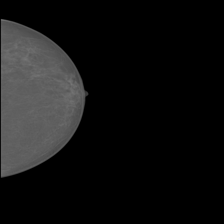

In [13]:
# show examples
density1benign = list(data_dir.glob('Density1Benign/*'))

for image_path in density1benign[:3]:
    display.display(Image.open(str(image_path)))

# Create batch

In [14]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255) # 0 to 1
train_data_gen = image_generator.flow_from_directory(directory=str(data_dir),
                                                     batch_size=32,
                                                     shuffle=True,
                                                     target_size=(224, 224),
                                                     classes = list(CLASS_NAMES))

Found 212 images belonging to 8 classes.


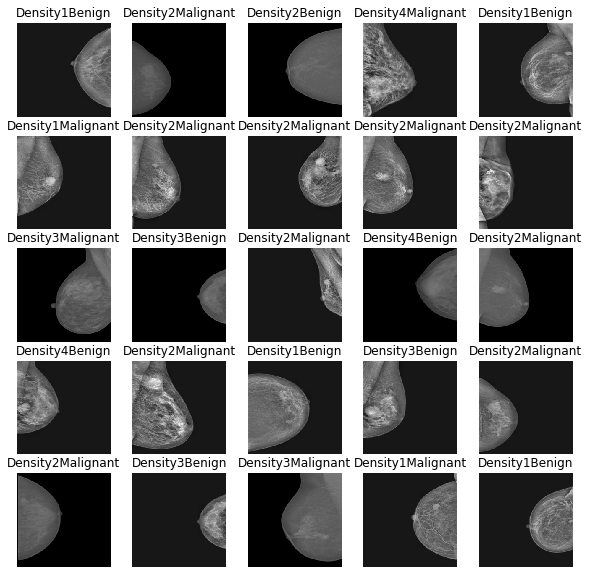

In [15]:
image_batch, label_batch = next(train_data_gen)
show_batch(image_batch, label_batch)

# Split data in train and test

In [16]:
# Divide in train and validation
image_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    shear_range=0.3,
    zoom_range=0.3,
    rotation_range=50,
    horizontal_flip=True,
    validation_split=0.2)

train_data_gen = image_generator.flow_from_directory(
        directory=str(data_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="training",
        classes = list(CLASS_NAMES))

val_data_gen = image_generator.flow_from_directory(
        directory=str(data_dir),
        batch_size=32,
        shuffle=True,
        target_size=(224, 224),
        subset="validation",
        classes = list(CLASS_NAMES))

Found 173 images belonging to 8 classes.
Found 39 images belonging to 8 classes.


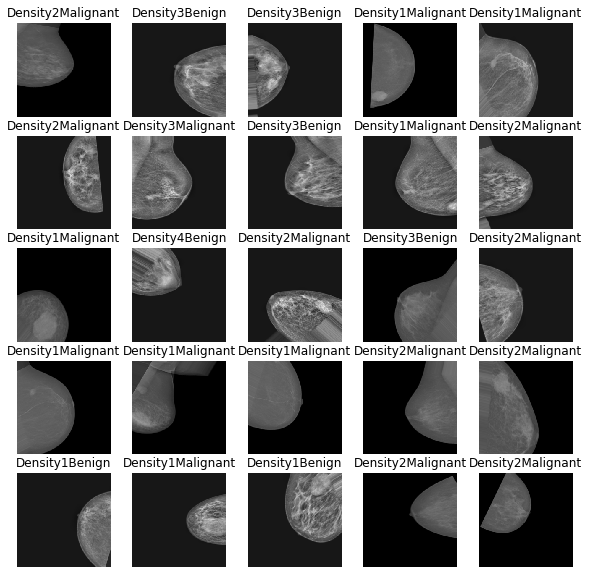

In [17]:
image_batch, label_batch = next(val_data_gen)
show_batch(image_batch, label_batch)

In [18]:
# RANDOM

In [19]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'))
for f in list_ds.take(8):
  print(f.numpy())


def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

IMG_WIDTH, IMG_HEIGHT = 224,224
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [IMG_WIDTH, IMG_HEIGHT])

def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

AUTOTUNE = tf.data.experimental.AUTOTUNE

labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
print(len(labeled_ds))

b'TestDataset/Density1Malignant/27829188 (2).png'
b'TestDataset/Density1Benign/50995789.png'
b'TestDataset/Density2Malignant/22613822 (2).png'
b'TestDataset/Density2Malignant/24055355 (2).png'
b'TestDataset/Density2Malignant/22613822.png'
b'TestDataset/Density1Malignant/30011674.png'
b'TestDataset/Density1Malignant/22670809 (2).png'
b'TestDataset/Density2Malignant/22613770 (2).png'
212


Image shape:  (224, 224, 3)
Label:  [False False False False False False False  True]


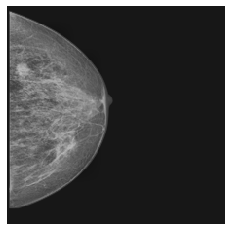

In [20]:
for image, label in labeled_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())
    plt.imshow(image)
    # plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
    plt.axis('off')


In [21]:
STEPS_PER_EPOCH = np.ceil(image_count/32)

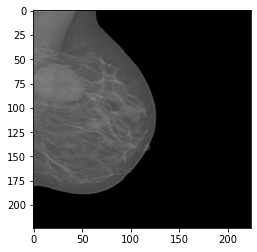

In [22]:
img = tf.io.read_file('./TestDataset/Density1Benign/20588680.png')
img = tf.image.decode_png(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32)
plt.imshow(img)